In [1]:
using Plots
using ParticleFilters
using Distributions
using StaticArrays
using LinearAlgebra
using Random
using StatsBase
using Reel

In [68]:
include("atan2.jl")
include("obs.jl")
rng = MersenneTwister(2);


In [3]:
const ANGLES = [30, 30, 30, 30, 60, 90, 120];

In [69]:
# random walk

POS_0 = [5.0, 45.0]
CRS_0 = 90 # target's course
HDG_0 = 90 # o/s heading


#input is course in degrees and rng
#returns next course in degrees
function next_crs(crs,rng)
    if rand(rng) < .9
        return crs
    end
    return (crs + rand(rng,[-1,1])*rand(rng, ANGLES)) % 360
end

# state as tuple (r, θ, crs, hdg) of target (hdg of o/s)
function f(state, control, rng)
    r, θ, crs, hdg = state
    x = r*sin(π/180*θ)
    y = r*cos(π/180*θ)
    pos = [x + cos(π/180*crs) - cos(π/180*hdg), y + sin(π/180*crs) - sin(π/180*hdg)]
    crs = next_crs(crs,rng)
    hdg = control
    r = sqrt(pos[1]^2 + pos[2]^2)
    θ = atan2(pos[1],pos[2])*180/π
    return [r, θ, crs, hdg]
end


# likelihood weight of observation "o" given x, a, xp


x = []
courses = []
observations = []
crs = CRS_0
pos = POS_0
hdg = HDG_0
for i in 1:100
    state = f((pos[1], pos[2], crs, hdg),0,rng)
    pos[1], pos[2], crs, hdg = state
    θ = state[2]
    r = state[1]
    if θ < 0 θ += 360 end
    #push!(x,(pos[1],pos[2]))
    push!(courses,crs)
    push!(observations,(r, θ, obs0(state), obs1(state), obs2(state), obs3(state)))
end


In [45]:

for i in observations
    #println(i)
end


In [46]:
model = ParticleFilterModel{Vector{Float64}}(f, g)

N = 1000
filter = SIRParticleFilter(model, N);



In [94]:
b = ParticleCollection([[10, 270, 90, 90] for i in 1:N])
x = [10, 270, 90, 90];
plots = []

for i in 1:200
    print(".")
    if i % 10 == 0
        u = 120 * (i % 3)
    else
        u = x[4]
    end
    x = f(x, u, rng)
    y = h(x, rng)
    b = update(filter, b, u, y)
    
    r = [row[1] for row in particles(b)]
    theta = [row[2] for row in particles(b)]*π/180
    x_theta = x[2]*π/180
    x_r = x[1]
    
    
    plt = plot(proj=:polar, lims=(0,100), size=(1000,1000))
    scatter!(theta, r, markersize=1, label="particles")
    scatter!([x_theta], [x_r], markersize=3, label="target")
          
    #plt = scatter([p[1] for p in particles(b)], [p[2] for p in particles(b)], color="black")
    #scatter!(plt, [x[1]], [x[2]], color=:blue, xlim=(-100,100), ylim=(-100,100), label="")
    push!(plots, plt)    
end

........................................................................................................................................................................................................

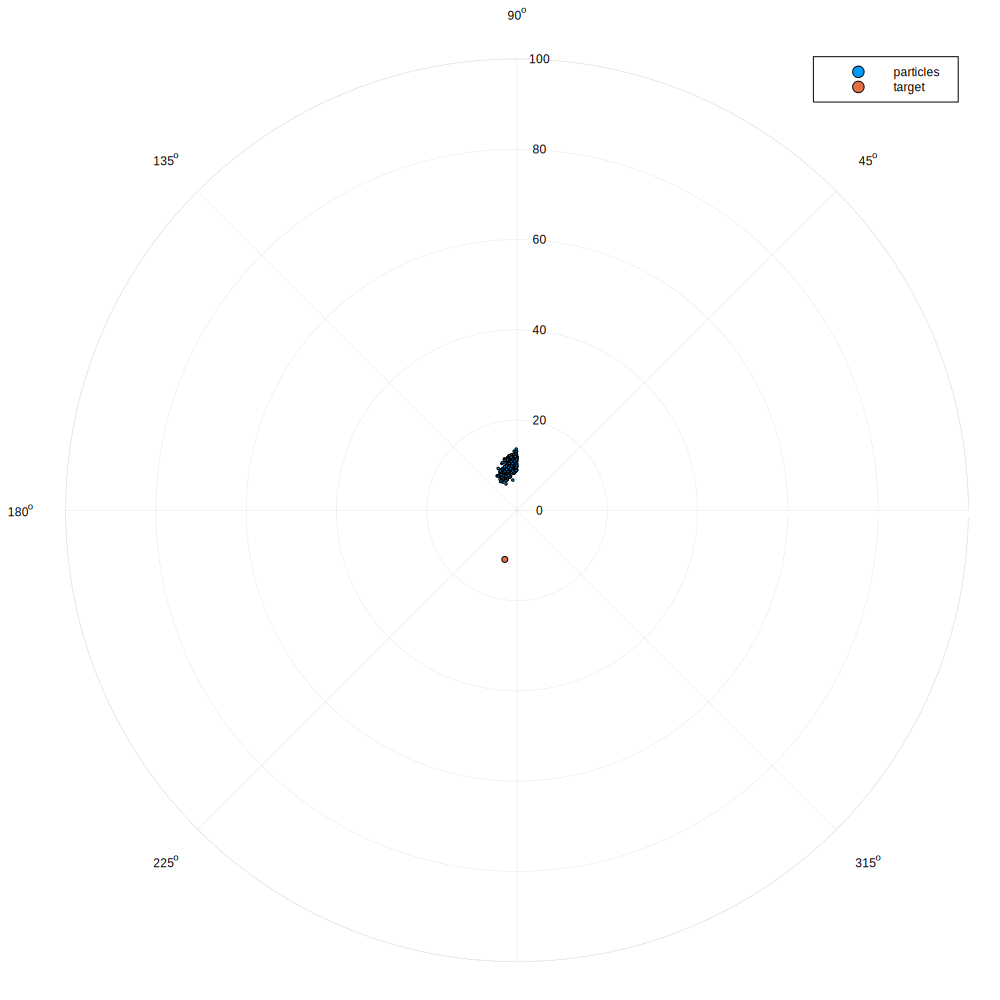

In [92]:
plots[27]

In [95]:
frames = Frames(MIME("image/png"), fps=10)
count = 0
for plt in plots
    if count % 2 == 0
        print(".")
        push!(frames, plt)
    end
    count += 1
end
write("output.gif", frames)

....................................................................................................

"output.gif"